# Hard Disk Drive (HDD) survival analysis in python

## Part I: data cleaning and preparation

Date: December 2017

Autor: [Alvaro Calle Cordon](www.linkedin.com/in/alvarocallecordon)

Notebook uses Python 2.7

## Descripción del notebook

**Notebooks**

This notebook prepares the HDD data to perform a survival analysis. It is the first notebook in a series of three where we explore the use of the python `lifelines` library for the analysis. 

- HDD_survival_II_KM: Kaplan-Meier non-parametric estimators
- HDD_survival_III_Cox: Application of CoxPH for hard drive failure data

**Data**

- Data has been retrieved from [BackBlaze](https://www.backblaze.com/b2/hard-drive-test-data.html)
- BackBlaze provides cleaned logfiles for the entire period and a small set of SQL files to create a sqlite database. This database will be read from the python notebook and analyzed

## Documentación

- https://github.com/MustafaOguz/Survival_Analysis
- https://github.com/search?l=Python&q=survival+analysis&type=Repositories&utf8=%E2%9C%93
- https://github.com/eduardoleon/survival
- https://github.com/jaredleekatzman/DeepSurv
- https://github.com/CamDavidsonPilon/lifelines
- http://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html
- http://blog.applied.ai/survival-analysis-part1

## Setup

### Initial setups

In [1]:
# plots in the notebook
%matplotlib inline

# fire ipython console
#%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

### Libraries

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sqlite3

### Customizations

## Loading the data

We assume that the sqlitle database has been created following BackBlaze instructions and that we have a basic database in the current local directory called `drive_stats.db`

In [3]:
# Where am I:
%pwd

u'/home/alvaro/Documentos/Analytics/Survival'

In [18]:
# check drive_stats.db is in the current directory
%ls

data_Q3_2016/     docs_Q3_2016+.zip   drive_survival.sql~
data_Q3_2016.zip  drive_stats.db      hard_drives_survival.ipynb
docs_Q3_2016/     drive_survival.sql


### SQL connector

In [5]:
cnx = sqlite3.connect('drive_stats.db')
csr = cnx.cursor()

### Pre-processed data from sqlitle db

In [49]:
# original data:
#query = 'select * from drive_stats'
#df = pd.read_sql(query, con=cnx, index_col=None, parse_dates='date')

# processed data:
query = 'select * from drive_survival'
df = pd.read_sql(query, con=cnx, index_col='diskid', parse_dates=['mindate','maxdate'])

In [50]:
print df.shape

(74574, 8)


In [51]:
df.head()

,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed
diskid,,,,,,,,
13H2B97AS,TOSHIBA DT01ACA300,3000592982016,2016-07-01,2016-09-30,92,20641,22825,0
13H32WEAS,TOSHIBA DT01ACA300,3000592982016,2016-07-01,2016-09-30,92,27892,30076,0
13H6A21GS,TOSHIBA DT01ACA300,3000592982016,2016-07-01,2016-09-30,92,27258,29442,0
13H7X2HAS,TOSHIBA DT01ACA300,3000592982016,2016-07-01,2016-09-30,92,14502,16686,0
13H85BMGS,TOSHIBA DT01ACA300,3000592982016,2016-07-01,2016-09-30,92,24503,26687,0


Now the new table `drive_survival` has, for each individual drive throughout the study:

- diskid/serial number
- model: drive manufacturer
- capacitybytes: capacity in bytes
- mindate/maxdate: first and final dates of operation
- nrecords: number of days in which it appears (this may not equal the elapsed days between first and final date)
- minhours/maxhours: first and final value of smart_9_raw, the summed hours in operation
- failed: a flag of whether the drive failed or survived the whole way through

In [26]:
df.dtypes

model                    object
capacitybytes             int64
mindate          datetime64[ns]
maxdate          datetime64[ns]
nrecords                  int64
minhours                  int64
maxhours                  int64
failed                    int64
dtype: object

## Initial Cleaning and Descriptive Analysis

Observe distributions for static data, missing values etc and take corrections accordingly

### 1. Reduction: remove disks with more than one failure

Here we will consider time-to-failure analysis, i.e., hard disks are remove as soon as they fail.

In [28]:
# check if there are hard-disks with more than a failure
df.groupby('failed').size()

failed
0    74215
1      359
dtype: int64

No need for reduction

### 2. Reduction: ignore drives that are too small or too big

In [36]:
df.groupby('capacitybytes').size()

capacitybytes
160041885696       189
250000000000         1
250059350016        97
320072933376        48
500107862016      1260
1000204886016      222
1500301910016       45
2000398934016     3872
3000592982016     6630
4000787030016    54629
5000981078016       45
6001175126016     2356
8001563222016     5180
dtype: int64

Decision: remove drives below 1.5TB and above 6TB, and remove single instance 1TB drives

(67577, 8)


capacitybytes
1500301910016       45
2000398934016     3872
3000592982016     6630
4000787030016    54629
5000981078016       45
6001175126016     2356
dtype: int64

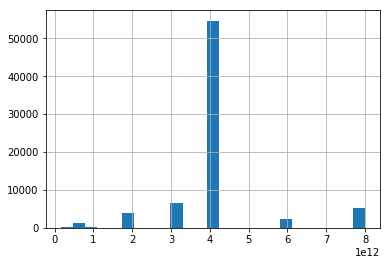

In [60]:
df['capacitybytes'].hist(bins=25)
condition = (df['capacitybytes'] > 1.5e12) & (df['capacitybytes'] < 7e12)
df = df.loc[condition]
print(df.shape)
df.groupby('capacitybytes').size()

### 3. Correction: properly identify manufacturer

The column `model` of the supplied raw data actually contains both manufacturer and model information. We need to separate manufacturer name from model column. 
- We take advantage of the fact that manufacturer and model are separated by a blank space.
- We need to account for the fact that manufacturer is not always present in model, therefore we include an if-condition in the apply function.
- The missing manufacturer corresponds to Seagate, therefore after the above transformation, we re-name ST** as Correct `SEAGATE`.
- Hitachi and HGST are the same manufacturer, we merge them.

In [65]:
df['model'].head()

diskid
13H2B97AS    TOSHIBA DT01ACA300
13H32WEAS    TOSHIBA DT01ACA300
13H6A21GS    TOSHIBA DT01ACA300
13H7X2HAS    TOSHIBA DT01ACA300
13H85BMGS    TOSHIBA DT01ACA300
Name: model, dtype: object

In [66]:
df['model'].apply(lambda x: x.split(" ")).head()

diskid
13H2B97AS    [TOSHIBA, DT01ACA300]
13H32WEAS    [TOSHIBA, DT01ACA300]
13H6A21GS    [TOSHIBA, DT01ACA300]
13H7X2HAS    [TOSHIBA, DT01ACA300]
13H85BMGS    [TOSHIBA, DT01ACA300]
Name: model, dtype: object

**Split manufacturer-model in two columns**

In [67]:
df['manufacturer'] = df['model'].apply(lambda x: x.split()[0])
df['model'] = df['model'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else x)
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C4040ALE630       75
              HDS724040ALE640       40
              HMS5C4040ALE640     7073
              HMS5C4040BLE640     9394
Hitachi       HDS5C3030ALA630     4496
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2631
              HDS722020ALA330     3723
              HDS723020BLA642        6
              HDS723030ALA640      990
              HDS723030BLE640        9
              HDS724040ALE640        3
ST2000VN000   ST2000VN000            5
ST31500541AS  ST31500541AS          44
ST33000651AS  ST33000651AS           1
ST4000DM000   ST4000DM000        35022
ST4000DX000   ST4000DX000          197
ST4000DX002   ST4000DX002            2
ST6000DM001   ST6000DM001            1
ST6000DX000   ST6000DX000         1891
TOSHIBA       DT01ACA300            46
              MD04ABA400V          146
              MD04ABA500V           45
WDC           WD15EARS               1
              WD20EFRX            

**Correct SEAGATE**

In [69]:
df['manufacturer'] = df['manufacturer'].apply(lambda x: 'SEAGATE' if x[:2] == 'ST' else x)
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C4040ALE630       75
              HDS724040ALE640       40
              HMS5C4040ALE640     7073
              HMS5C4040BLE640     9394
Hitachi       HDS5C3030ALA630     4496
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2631
              HDS722020ALA330     3723
              HDS723020BLA642        6
              HDS723030ALA640      990
              HDS723030BLE640        9
              HDS724040ALE640        3
SEAGATE       ST2000VN000            5
              ST31500541AS          44
              ST33000651AS           1
              ST4000DM000        35022
              ST4000DX000          197
              ST4000DX002            2
              ST6000DM001            1
              ST6000DX000         1891
TOSHIBA       DT01ACA300            46
              MD04ABA400V          146
              MD04ABA500V           45
WDC           WD15EARS               1
              WD20EFRX            

**Merge Hitachi and HGST**

In [74]:
df.loc[df['manufacturer'] == 'Hitachi', 'manufacturer'] = 'HGST'
df.groupby(['manufacturer','model']).size()

manufacturer  model          
HGST          HDS5C3030ALA630     4496
              HDS5C3030BLE630        1
              HDS5C4040ALE630     2706
              HDS722020ALA330     3723
              HDS723020BLA642        6
              HDS723030ALA640      990
              HDS723030BLE640        9
              HDS724040ALE640       43
              HMS5C4040ALE640     7073
              HMS5C4040BLE640     9394
SEAGATE       ST2000VN000            5
              ST31500541AS          44
              ST33000651AS           1
              ST4000DM000        35022
              ST4000DX000          197
              ST4000DX002            2
              ST6000DM001            1
              ST6000DX000         1891
TOSHIBA       DT01ACA300            46
              MD04ABA400V          146
              MD04ABA500V           45
WDC           WD15EARS               1
              WD20EFRX             138
              WD30EFRX            1087
              WD40EFRX            

### 4. Correction: make capacities human readable

In [75]:
df['capacity'] = df['capacitybytes'].apply(lambda x: '{}TB'.format(round(x / 1e12,2)))
df.groupby(['capacity']).size()

capacity
1.5TB       45
2.0TB     3872
3.0TB     6630
4.0TB    54629
5.0TB       45
6.0TB     2356
dtype: int64

### 5. Reduction: Remove under-represented manufacturer-capacities

We want to make the survival analysis quite general, so if possible, we want to avoid subgroups that are too small

capacity      1.5TB   2.0TB   3.0TB    4.0TB  5.0TB   6.0TB
manufacturer                                               
HGST            NaN  3729.0  5496.0  19216.0    NaN     NaN
SEAGATE        44.0     5.0     1.0  35221.0    NaN  1892.0
TOSHIBA         NaN     NaN    46.0    146.0   45.0     NaN
WDC             1.0   138.0  1087.0     46.0    NaN   464.0


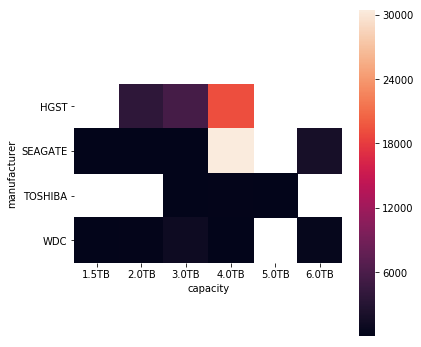

In [82]:
gp = df.groupby(['manufacturer','capacity']).size().unstack()
print gp
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=True, cbar=True)

**Decision: Exclude Toshiba**

In [83]:
df = df.loc[df['manufacturer'] != 'TOSHIBA']
df.shape

(67340, 10)

**View model - capacities**

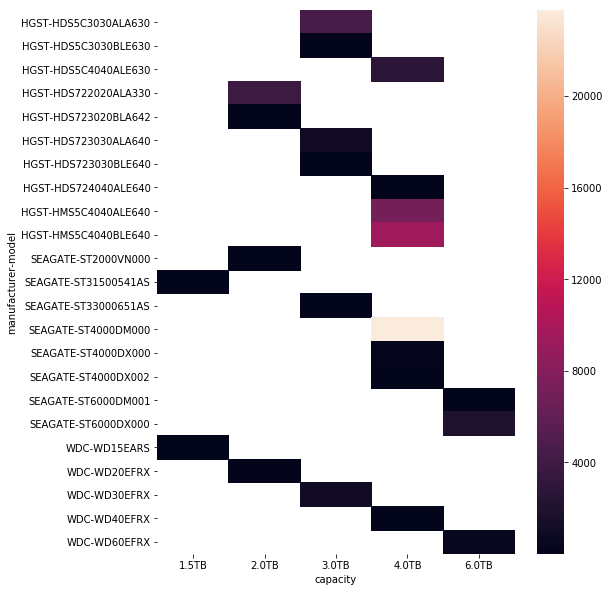

In [86]:
gp = df.groupby(['manufacturer','model','capacity']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,10), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0], robust=True, square=False, cbar=True)

**Observation**: As one might expect, a model only ever appears with a single capacity, so the model-capacity information is mutually redudant.

> For survival analysis we will use only manufacturer and capacity features, ignoring model number which is redundant information

## Specific Cleaning for Survival Durations

Observe distributions for time-based data and durations - these are critical for survival analysis

### 1. Feature Engineering: transform dates to month-year

min/max dates are the first and final dates of operation

In [87]:
df['mindateym'] = df['mindate'].apply(lambda x: x.strftime('%Y%m'))
df['maxdateym'] = df['maxdate'].apply(lambda x: x.strftime('%Y%m'))

In [88]:
df.head()

,model,capacitybytes,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,,
5XW00J2Z,ST31500541AS,1500301910016,2016-07-21,2016-09-30,62,46815,48301,0,SEAGATE,1.5TB,201607,201609
5XW029ZZ,ST31500541AS,1500301910016,2016-07-21,2016-09-30,62,50682,52168,0,SEAGATE,1.5TB,201607,201609
5XW02BHJ,ST31500541AS,1500301910016,2016-07-21,2016-09-30,62,45703,47362,0,SEAGATE,1.5TB,201607,201609
5XW02L6V,ST31500541AS,1500301910016,2016-07-21,2016-09-30,62,54121,55780,0,SEAGATE,1.5TB,201607,201609
5XW02N56,ST31500541AS,1500301910016,2016-07-21,2016-09-30,62,50686,52172,0,SEAGATE,1.5TB,201607,201609


**View distribution of first and final date of operation**

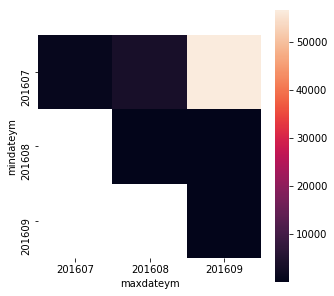

In [96]:
gp = df.groupby(['mindateym','maxdateym']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5), squeeze=False)
ax = sns.heatmap(gp, mask=pd.isnull(gp), ax=axes[0,0],robust=True, square=True, cbar=True)

**Observation**: there's a HUGE number of drives with a final log entry of '201609' at the end of the study.
> We clearly also have some strong right-censoring. This is manageable

**Observation**: there's few (if any) drives with an intitial log entry of '201607' at the start of the study.

> This is an indication of no left-truncation.

## Using the SMART features to estimate disk duration

The column SMART_9_RAW in the original logfiles is apparently a *cumulative sum of hours that the drive has been in use since birth*

> Perhaps we can use SMART_9_RAW as an indicator of hard-drive failure?

Notice that we preprocessed the min and max smart_9_raw values during the table creation in SQL file `drive_survival.sql`

### 1. Reduction: remove rows without minhours and maxhours information

In [92]:
print(pd.isnull(df['minhours']).sum())
print(pd.isnull(df['maxhours']).sum())

0
0


In [93]:
print(df.shape[0])
print(df['minhours'].apply(np.isreal).sum())
print(df['maxhours'].apply(np.isreal).sum())

67340
67340
67340


Observation: no problems with non-numeric values for maxhours
> We keep the data set as it is

** Look at the distribution of failures in terms of total working hours **

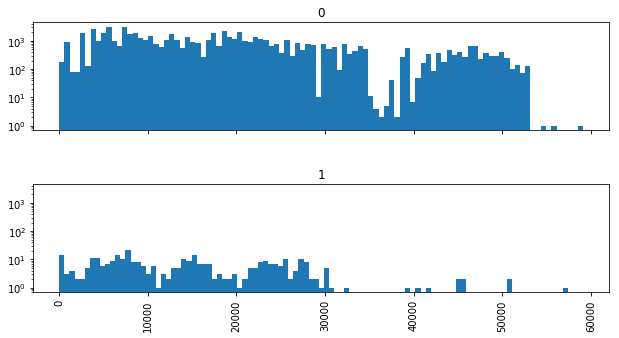

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5), squeeze=False)
ax=df.hist(column='maxhours', by='failed', ax=axes[0,0], bins=100, layout=(2,1), log=True, sharex=True, sharey=True)

**Observation**: The distributions appear reasonable, no readily apparent bunching of disks around particular values of hours

> We will use maxhours for our crucial measure of lifespan

## Drop unnecessary columns

We will drop the column `capacitybytes` because we have created a more human-redeable one `capacity`

In [105]:
del df['capacitybytes']

## Final look

In [106]:
df.head()

,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
5XW00J2Z,ST31500541AS,2016-07-21,2016-09-30,62,46815,48301,0,SEAGATE,1.5TB,201607,201609
5XW029ZZ,ST31500541AS,2016-07-21,2016-09-30,62,50682,52168,0,SEAGATE,1.5TB,201607,201609
5XW02BHJ,ST31500541AS,2016-07-21,2016-09-30,62,45703,47362,0,SEAGATE,1.5TB,201607,201609
5XW02L6V,ST31500541AS,2016-07-21,2016-09-30,62,54121,55780,0,SEAGATE,1.5TB,201607,201609
5XW02N56,ST31500541AS,2016-07-21,2016-09-30,62,50686,52172,0,SEAGATE,1.5TB,201607,201609


In [107]:
print(df.shape)
df.describe()

(67340, 11)


,nrecords,minhours,maxhours,failed
count,67340.000000,67340.000000,67340.000000,67340.000000
mean,87.622023,16216.028482,18299.788165,0.005034
std,15.140069,12750.666147,12635.771663,0.070773
min,1.000000,1.000000,8.000000,0.000000
25%,92.000000,5723.000000,7885.000000,0.000000
50%,92.000000,14477.000000,16660.000000,0.000000
75%,92.000000,22320.000000,24504.000000,0.000000
max,92.000000,57440.000000,59097.000000,1.000000


## Write back to DB

In [108]:
df.to_sql('drive_survival_prepared', con=cnx, if_exists='replace', index_label='diskid')

## Summary

To summarise the initial data prep notebook:

- After excluding erroneous data and some drives belonging to under-represented manufacturers and odd capacities, we have records for 67340 harddrives
- We may have left-truncation, with harddrives already in daily operation at the first date of the study. This means that our harddrive lifetime can't simply be a calculated duration between first and final dates of operation.
- Fortunately we have access to the S.M.A.R.T. 9 statistic, which is a running total of hours of operation. We can use this to calculate a lifetime of operational hours.
- We have two clean features to use for predicting lifespan: manufacturer and capacity, and a max observed lifespan of approx 48,000 hours / 2,000 days / 5.5 years, which may lead to some useful real-world insights.